<h1><center>Topological Data Analysis</center></h1>

![Url](https://thumbs.gfycat.com/DisgustingBlandDromedary-size_restricted.gif)

<p style="text-align: center;">Gif from: https://gfycat.com/disgustingblanddromedary</p>

### Background
The tools from Topological Data Analysis (TDA) emerged in response to the issues in high-dimensional data. Essentially, TDA seeks to utilize tools from topology, a brach of mathematics “concerned with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling and bending, but not tearing or gluing,” [1] to analyze data. How does topology relate to data analysis? TDA seeks to utilize mathematical, statistical, and algorithmic methods to make inferences and analyze the topological structure and geometric structures of data [2]. 

This notebook (and the remaining notebooks) are designed to introduce data scientists to TDA without needing a background in math.

Before exploring TDA applications, this particular notebook will cover some of the most important topics in TDA.

### Simplicial Complex

Informally, a simplex is a generalization of the notion of a trigangle in _n_ dimensional space. Formally, 

In [1]:
import numpy as np
import scipy as sp
import ripser
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
import scipy.io as sio
import time
import copy

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
from sklearn.neighbors import kneighbors_graph

from matplotlib.patches import Circle
from persim import plot_diagrams
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import random 
import numpy as np

from ripser import ripser
from ripser import Rips
from persim import plot_diagrams

from IPython.display import display, clear_output
import time

from ipywidgets import interact, widgets

%matplotlib inline

In [2]:
def maxmin(dist_matrix, n):
    '''
    Given a distance matrix retunrs a maxmin subsampling and the covering radious 
    corresponding to the subsampled set.
    
    :param dist_matrix: Distance matrix
    :param n: Size of subsample set.
    :returns L: List of indices corresponding to the subsample set.
    :return cr: Covering radious for the subsample set.
    '''
    L = [np.random.randint(0,len(dist_matrix))]
    
    dist_to_L = dist_matrix[ L[-1] ,:]
    
    for i in range(n-1):
        ind = np.argmax( dist_to_L )
        L.append(ind)
        
        dist_to_L = np.minimum(dist_to_L, dist_matrix[L[-1], :])
        
    cr = np.max(dist_to_L)

    return L, cr

def uniform_sampling(dist_matrix, n):
    '''
    Given a distance matrix retunrs an subsamplig that preserves the distribution of the original data set 
    and the covering radious corresponding to the subsampled set.
    
    :param dist_matrix: Distance matrix
    :param n: Size of subsample set.
    :returns L: List of indices corresponding to the subsample set.
    :return cr: Covering radious for the subsample set.
    '''
    num_points = dist_matrix.shape[0]
    
    L = np.random.choice(num_points, n)
    
    dist_to_L = np.min(dist_matrix[L,:], axis=0)
    
    return L, np.max(dist_to_L)

In [3]:

n=200
theta = np.random.uniform(0, 2*np.pi, n)

# Generate radii with Gaussian noise centered at 1
r = 1 + np.random.normal(0, 0.05, n)
r[0] = 0
# Use angles and radii to generate circle 
X = r[:,np.newaxis]*np.concatenate((np.cos(theta)[:,np.newaxis], np.sin(theta)[:,np.newaxis]), axis=1)
# Compute the distance matrix for the data set X using auclidean distance.
dm_X = distance.cdist(X,X)

ind_L, cover_r = uniform_sampling(dm_X, 20)

# scatter plot the landmark subset
fig, ax = plt.subplots()
#plt.scatter(X[:,0], X[:,1], c=theta, cmap='jet')
plt.scatter(X[ind_L,0], X[ind_L,1], c='black')
R=np.arange(0,1.5,0.1)
# Plot balls or radious defined by the covering radious of the landmark set
for point in range(len(ind_L)):
    cir = Circle((X[ind_L[point],0], X[ind_L[point],1]),1, color=(.5,.5,.5,0.2))
    ax.add_patch(cir)
    
    
    
fig = plt.figure(figsize = (12,7))
time.sleep(0.2)
clear_output(wait=True) # Clear output for dynamic display
display(fig)            # Reset display
fig.clear()             # Prevent overlapping and layered plots
plt.close();

      
ax.set_ylim(-1-cover_r,1+cover_r)
ax.set_xlim(-1-cover_r,1+cover_r)

<Figure size 864x504 with 0 Axes>

(-1.922760288967155, 1.922760288967155)

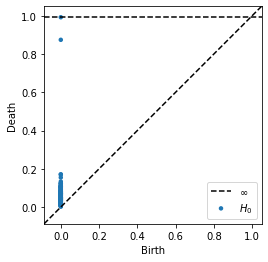

In [4]:
cir = Circle((X[ind_L[point],0], X[ind_L[point],1]),.5, color=(.5,.5,.5,0.2))
dgms = ripser(X, maxdim=0, thresh=1)['dgms']
plot_diagrams(dgms, show=True)

In [5]:
# cell to do interactive plotting
n=200
theta = np.random.uniform(0, 2*np.pi, n)

# Generate radii with Gaussian noise centered at 1
r = 1 + np.random.normal(0, 0.05, n)
r[0] = 0
# Use angles and radii to generate circle 
X = r[:,np.newaxis]*np.concatenate((np.cos(theta)[:,np.newaxis], np.sin(theta)[:,np.newaxis]), axis=1)
# Compute the distance matrix for the data set X using auclidean distance.
dm_X = distance.cdist(X,X)

ind_L, cover_r = uniform_sampling(dm_X, 20)

# add slider

def update(radius = 0.25):
    # scatter plot the landmark subset
    # put circles on the left side; JK 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5,4.5))
    #plt.scatter(X[:,0], X[:,1], c=theta, cmap='jet')
    ax1.scatter(X[ind_L,0], X[ind_L,1], c='black')
    R=np.arange(0,1.5,0.1)
    # Plot balls or radious defined by the covering radious of the landmark set
    for point in range(len(ind_L)):
        cir = Circle((X[ind_L[point],0], X[ind_L[point],1]),radius, color=(.5,.5,.5,0.2))
        ax1.add_patch(cir)

    ax1.set_ylim(-1-cover_r,1+cover_r)
    ax1.set_xlim(-1-cover_r,1+cover_r)

    # plot persistance diagram; JK
    cir = Circle((X[ind_L[point],0], X[ind_L[point],1]),.5, color=(.5,.5,.5,0.2))
    dgms = ripser(X, maxdim=0, thresh=1)['dgms']
    plot_diagrams(dgms, show=True, ax=ax2)

    # to reduce the margins inside plot; JK
    plt.tight_layout()
    return

# define range and step for radius: from 0.0 till 0.5 (inclusive) with step 0.01
interact(update, radius=(0.0, 0.5, 0.01));

interactive(children=(FloatSlider(value=0.25, description='radius', max=0.5, step=0.01), Output()), _dom_class…

In [12]:
# def animate_H0(data, radius):
#     fig = plt.figure(figsize=(6,6))
#     fig.suptitle('Persistent Homology of a Circle (H0)')
#     plt.subplot(121)
#     plt.scatter(X[ind_L,0], X[ind_L,1], c='red')
#     for point in range(len(ind_L)):
#         cir = Circle((X[ind_L[point],0], X[ind_L[point],1]), cover_r, color=(0.7,0.2,0.5,0.2))
#         add_patch(cir)
#     plt.subplot(122)
#     dgms = ripser(X, maxdim=0, thresh=radius)['dgms']
#     plt.plot_diagrams(dgms, show=True)


    

# plt.scatter(X[ind_L,0], X[ind_L,1], c='red')
# plt.subplot(121)
# plt.scatter(X[ind_L,0], X[ind_L,1], c='red')
# # Plot balls or radious defined by the covering radious of the landmark set
# for point in range(len(ind_L)):
#     cir = Circle((X[ind_L[point],0], X[ind_L[point],1]), cover_r, color=(0.6,0.6,0.6,0.2))
#     ax.add_patch(cir)
# plt.set_ylim(-1-cover_r,1+cover_r)
# plt.set_xlim(-1-cover_r,1+cover_r)

# plt.subplot(122)
# dgms = ripser(X, maxdim=0, thresh=1)['dgms']
# plot_diagrams(dgms, show=True)

### Homology

#### Betti Number

#### Euler Formula



### Persistent Homology

words
![Url](https://miro.medium.com/max/1400/1*9dqnnfbqz0WfjlhONkD2iQ.gif)

### <center> Ripser</center>

<img src="http://ripser.scikit-tda.org/_static/logo.png" width="25%">

<p style="text-align: center;">Image from: http://ripser.scikit-tda.org/</p>

[Ripser](https://ripser.scikit-tda.org/) is a persistent homology package for Python. 

#### Ripser Parameters:
- __X__: data array
- __maxdim__: maximum homology dimension
- __thresh__: maximum distances considered when constructing filtration
- __coeff__: compute homology with coefficients in the prime field
- __distance_matrix__: indicator that X is a distance matrix
- __do_cocycles__: indicator of whether to compute cocycles
- __metric__: metric to use when calculating distance between instances in a feature array

### <center>Mapper</center>

<img src="https://kepler-mapper.scikit-tda.org/_static/logo.png" width="23%">

<p style="text-align: center;">Image from: https://kepler-mapper.scikit-tda.org/</p>

[Kelper Mapper](https://kepler-mapper.scikit-tda.org/) is the Python TDA Mapper package.
#### Mapper Parameters:
- __Data__: Point Cloud Data
- __Filter Function__: A filter function is a function on the data set, $f: X \to \mathbb{R}^2$
    - Filter functions can help reveal possible geometric structures within the data [3].
    - Some choices for [filter functions](http://danifold.net/mapper/filters.html) include _eccentricity,_ _Kernel Density Estimator,_ _k-th nearest neighbor,_ _k-th eigenvector,_ or the _Graph Laplacian._
- __Clustering Technique__: 
- __Number of Interval__:
- __Percent Overlap__:

If one is intersted in seeking additional information about TDA or would like to understand the magic behind TDA, consider watching the following YouTube videos. They are provided by [Jose Perea](https://www.joperea.com/teaching/spring2020), a professor of Mathematics at Michigan State University.

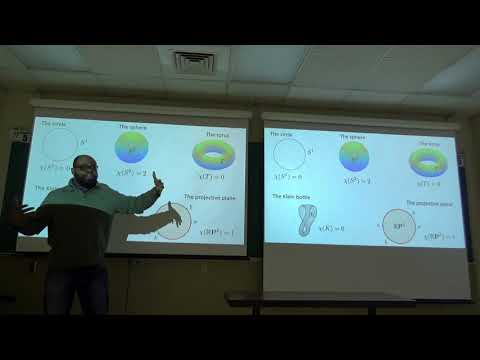

In [12]:
from IPython.display import YouTubeVideo
YouTubeVideo("BDQDpdTc-A4",width=640,height=360)

### References

[1] https://en.wikipedia.org/wiki/Topology

[2] https://arxiv.org/abs/1710.04019

[3] http://www.diva-portal.org/smash/get/diva2:900997/FULLTEXT01.pdf